# 🧠 LangChain + LangGraph + Groq Tutorial: Tool-Enhanced LLM Workflow

This tutorial shows how to:
- Set up an LLM from Groq (`deepseek-r1-distill-llama-70b`)
- Create and bind custom tools (math, search, finance)
- Use `LangGraph` to manage tool calling workflows
- Visualize and test a tool-augmented agent
- Extend to real-world tasks like stock analysis and query resolution


In [1]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0
)

response = llm.invoke("what is length of wall of china?")
print(response.content)


<think>
Okay, so I need to figure out the length of the Great Wall of China. I remember hearing that it's really long, but I'm not exactly sure how long. I think it's somewhere in the thousands of miles, but I'm not certain. Let me try to break this down.

First, I know the Great Wall is a series of fortifications built across several Chinese dynasties. It wasn't built all at once, so maybe that's why the length can vary. I've heard different numbers before, like 13,000 miles or 21,000 kilometers. But I'm not sure which one is accurate.

I should consider the sources of this information. Maybe some people measure it differently. For example, if you include all the branches and sections, it might add up to a longer distance. But if you just take the main wall, it might be shorter. I think the Chinese government did a survey a while back, so that might be a reliable source.

Wait, I think they used advanced technology like GPS and satellites to measure it more accurately. That would make

## 🧰 Define Custom Math Tools

In [3]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

## 🌍 Add Built-In Search Tool

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()
print(search.invoke("what is the latest update on iphone17 release?"))


Apple has just released iOS 17.6.1, the latest iPhone software update. If you're getting a sense of déjà vu, you have good reason. That's because Apple launched iOS 17.6.1 already, on August ... The newly released iOS 17.7 is Apple's way of offering important security updates to users who choose not to upgrade to iOS 18 just yet. On your iPhone, you can find the new software update by ... We get new iPhone colors every year, and while we don't know what colors to expect for the iPhone 17 models just yet, Apple undoubtedly has something fresh in the works. Apple's next major release, the iPhone 17 series, is shaping up to be one of its most exciting launches in years. With a mix of cutting-edge design, powerful new hardware, and a shift in strategy for its product lineup, there's a lot more happening under the surface than usual. Here's everything you need to know about the latest updates, features, and when you can expect to get your ... • The iPhone 17's display may not match what the

## 🛠️ Bind Tools to LLM

In [ ]:
tools = [multiply, add, divide, search]
llm_with_tools = llm.bind_tools(tools)



## 📥 Tool Invocation Examples

In [12]:
response=llm_with_tools.invoke("what is 10/2?")
response.content

''

In [13]:
response.tool_calls

[{'name': 'divide',
  'args': {'a': 10, 'b': 2},
  'id': 'kmwzvddpe',
  'type': 'tool_call'}]

In [14]:
response=llm_with_tools.invoke("what is a current age of the TATA Group?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'yjgk6xt8q', 'function': {'arguments': '{"query":"TATA Group founding year"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 298, 'prompt_tokens': 402, 'total_tokens': 700, 'completion_time': 1.232588635, 'prompt_time': 0.035551437, 'queue_time': 0.22008251400000003, 'total_time': 1.268140072}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fd9fceb0-8004-48c8-9e01-85a32503e4d4-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'TATA Group founding year'}, 'id': 'yjgk6xt8q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 402, 'output_tokens': 298, 'total_tokens': 700})

In [15]:
response.content

''

In [16]:
response.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'TATA Group founding year'},
  'id': 'yjgk6xt8q',
  'type': 'tool_call'}]

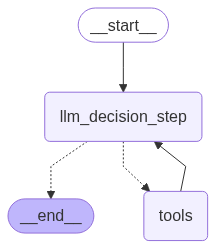

In [27]:
# 📦 Step 1: Import required modules and components
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# 📌 Step 2: Define the system prompt to guide LLM behavior
SYSTEM_PROMPT = "You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."

# 🧩 Step 3: Define the LLM decision-making function
def function_1(state: MessagesState):
    # Extract user message(s) from the current graph state
    user_question = state["messages"]

    # Combine system prompt with user input
    input_question = [SYSTEM_PROMPT] + user_question

    # Call the LLM with tools enabled
    response = llm_with_tools.invoke(input_question)

    # Return the updated message list
    return {"messages": [response]}

# 🧪 Step 4: (Optional) Simulate a sample user query for manual testing
user_query = ["tell me what is 2+2"]
[SYSTEM_PROMPT] + user_query  # This line is just for inspection/debugging

# 🏗️ Step 5: Initialize a LangGraph state machine using message-based state
builder = StateGraph(MessagesState)

# 🔧 Step 6: Add the LLM decision node to the graph
builder.add_node("llm_decision_step", function_1)

# ⚙️ Step 7: Add the tool node (make sure `tools` is defined, e.g., [add, search, get_stock_price])
builder.add_node("tools", ToolNode(tools))

# 🔀 Step 8: Define the flow of execution between nodes
builder.add_edge(START, "llm_decision_step")  # Start from the LLM node
builder.add_conditional_edges("llm_decision_step", tools_condition)  # Branch to tools if needed
builder.add_edge("tools", "llm_decision_step")  # Return to LLM after tool use

# ✅ Step 9: Compile the LangGraph into an executable graph
react_graph = builder.compile()

# 📊 Step 10: Visualize the graph as a Mermaid diagram
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [29]:
message=[HumanMessage(content="What is 2 times of narendramodi's age?")]
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content="What is 2 times of narendramodi's age?", additional_kwargs={}, response_metadata={}, id='1b3c8774-dc4d-4165-ae57-143d7271f820'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mmjdwp7ba', 'function': {'arguments': '{"query":"Narendra Modi age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 308, 'prompt_tokens': 423, 'total_tokens': 731, 'completion_time': 1.12, 'prompt_time': 0.027269262, 'queue_time': 0.22872984700000001, 'total_time': 1.147269262}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3fe2d11f-ce90-47f9-961f-b8980cef2c23-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Narendra Modi age'}, 'id': 'mmjdwp7ba', 'type': 'tool_call'}], usage_metadata={'input_tokens': 423, 'output_tokens': 308, 'total_tokens': 731}),
  ToolMessage(content='Narendra M

In [31]:
message = [HumanMessage(content="How much is the net worth of Elon Musk, and divide it by 2?")]
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content='How much is the net worth of Elon Musk, and divide it by 2?', additional_kwargs={}, response_metadata={}, id='31d1f1fa-d085-45c0-9383-72cf0a273c4f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cd6t40gww', 'function': {'arguments': '{"query":"Elon Musk net worth 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 602, 'prompt_tokens': 427, 'total_tokens': 1029, 'completion_time': 2.189090909, 'prompt_time': 0.034060192, 'queue_time': 0.216800267, 'total_time': 2.223151101}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3734afb3-6a9a-49ea-a718-3e7940b44156-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk net worth 2023'}, 'id': 'cd6t40gww', 'type': 'tool_call'}], usage_metadata={'input_tokens': 427, 'output_tokens': 602, 'total_tokens': 1029}

In [33]:
message = [HumanMessage(content="What is the speed of light in m/s and multiply it by 10?")]
response=react_graph.invoke({"messages":message})
response["messages"][-1].content

'The speed of light in meters per second is 299,792,458 m/s. When multiplied by 10, the result is 2,997,924,580 m/s. \n\n**Step-by-Step Explanation:**\n\n1. **Identify the Speed of Light:**\n   - The speed of light in a vacuum is exactly 299,792,458 meters per second (m/s).\n\n2. **Multiply by 10:**\n   - To find ten times the speed of light, multiply 299,792,458 m/s by 10.\n   - Calculation: 299,792,458 m/s * 10 = 2,997,924,580 m/s.\n\n3. **Final Result:**\n   - The result of multiplying the speed of light by 10 is 2,997,924,580 m/s.\n\nThis process ensures that the calculation is accurate and follows the correct mathematical operations.'

In [34]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply it by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (mpv48yn2b)
 Call ID: mpv48yn2b
  Args:
    a: 299792000
    b: 10
================================= Tool Message =================================
Name: multiply

2997920000
================================== Ai Message ==================================
Tool Calls:
  multiply (avcy9z692)
 Call ID: avcy9z692
  Args:
    a: 299792000
    b: 10
================================= Tool Message =================================
Name: multiply

2997920000
================================== Ai Message ==================================

The speed of light in meters per second is 299,792,458 m/s. When multiplied by 10, the result is 2,997,924,580 m/s. 

**Step-by-Step Explanation:**

1. **Identify the Speed of Light:**
   - The speed of light in a vacuum 

# 🔧Tool-Augmented LLM Workflow with LangGraph

This notebook shows how to build a tool-augmented LLM system using LangGraph. The system supports arithmetic operations, web search, and stock price lookups.

In [53]:
import yfinance as yf
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"
     

In [54]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $196.58.'

In [55]:
get_stock_price.invoke("TSLA")

'The last closing price of TSLA was $322.05.'

In [56]:
tools

[StructuredTool(name='get_stock_price', description="Fetches the previous closing price of a given stock ticker from Yahoo Finance.\n\nArgs:\n    ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').\n\nReturns:\n    str: A message with the stock's previous closing price.", args_schema=<class 'langchain_core.utils.pydantic.get_stock_price'>, func=<function get_stock_price at 0x000001974CDB7E20>)]

In [58]:
tools = [add, multiply, divide, search,get_stock_price]
llm_with_tools=llm.bind_tools(tools)
response=llm_with_tools.invoke("can you give me a latest stock price of adani greens?")
response.content

''

In [59]:
response.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.NS'},
  'id': '0xcvtp3gw',
  'type': 'tool_call'}]

In [60]:
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

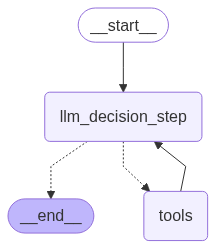

In [62]:

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END
builder = StateGraph(MessagesState)



builder.add_node("llm_decision_step", function_1)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "llm_decision_step")
builder.add_conditional_edges("llm_decision_step", tools_condition)
builder.add_edge("tools", "llm_decision_step")
react_graph = builder.compile()
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [63]:
# Step 8: Test the system
from langchain_core.messages import HumanMessage
message = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
response = react_graph.invoke({"messages": message})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (meekyqqdb)
 Call ID: meekyqqdb
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $196.58.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (43knvpqyq)
 Call ID: 43knvpqyq
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $196.58.
================================== Ai Message ==================================

The last closing price of AAPL was $196.58. Adding 1000 to this price:

196.58 + 1000 = 1196.58

So, the result is **$1,196.58**.


Assignment:
    
AI Travel Agent & Expense Planner(Purpose: Trip planning for any city worldwide with Realtime data.")

• Real-time weather information
• Top attractions and activities
• Hotel cost calculation (per day × total days)
• Currency conversion to user's native currency
• Complete itinerary generation
• Total expense calculation
• generate a summary of the entire output

user_input
  |
search attraction and activity
1. search attracation
2. search restaurant
3. search activity
4. search transportation
  |
search weather forcasting
1. get current weather
2. get weather forcast
  |
search hotel costs
1. search hotel
2. estimate the hotel cost
3. budget_range
  |
calculate total cost
1. add
2. multiply
3. calculated total cost
4. calcualte the daily budget
    | 
currency_converion
1. get exchnage rate
2. convert currancy
    | 
Itinery generation
1. get day plan
2. crete full itinery
    |
create Trip Summary
    |
Retun complete traval plan

Note: if you know the OOPS then design this entire system using object and class in modular fashion.


deadline is till next friday 9PM IST


 everyone you can submit the assignments in this form. MAke sure to have one GitHub link and put all the assignments there https://forms.gle/g8RZ4qx8yvNcih4B7    
    